In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle
import keras
import time
import cv2
import os

from keras import preprocessing
from keras import regularizers
from keras import activations
from keras import optimizers
from keras import callbacks
from keras import layers
from keras import losses
from keras import models

from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16

In [2]:
data_base_path = 'E:/Data/Video_Frame_Interpolation/processed/med_motion'
data_creation_time = '1681975868'
model_base_path = 'E:/OneDrive - Akademia Górniczo-Hutnicza im. Stanisława Staszica w Krakowie/Programming/Labs/Frame_booster/models'
width, height = 224, 128

In [3]:
def load_data(base_path, creation_time, width, height):
    with open(os.path.join(base_path, f'x_train_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        x_train = pickle.load(file)
        
    with open(os.path.join(base_path, f'y_train_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        y_train = pickle.load(file)
        
    with open(os.path.join(base_path, f'x_test_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        x_test = pickle.load(file)
        
    with open(os.path.join(base_path, f'y_test_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        y_test = pickle.load(file)
        
    with open(os.path.join(base_path, f'x_valid_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        x_valid = pickle.load(file)
        
    with open(os.path.join(base_path, f'y_valid_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        y_valid = pickle.load(file)
        
    return (np.array(x_train)/255.0).astype('float32'), (np.array(x_test)/255.0).astype('float32'), (np.array(x_valid)/255.0).astype('float32'), (np.array(y_train)/255.0).astype('float32'), (np.array(y_test)/255.0).astype('float32'), (np.array(y_valid)/255.0).astype('float32')

In [4]:
x_train, x_test, x_valid, y_train, y_test, y_valid = load_data(
    data_base_path,
    data_creation_time,
    width, 
    height
)

In [5]:
print(f'Train size: {len(x_train)}')
print(f'Test size: {len(x_test)}')
print(f'Validation size: {len(x_valid)}')

Train size: 918
Test size: 256
Validation size: 103


## Model

In [34]:
class PyramidFeatureExtractor(layers.Layer):
    def __init__(self, **kwargs):
        # initialize super class
        super(PyramidFeatureExtractor, self).__init__(**kwargs)
        
        # for pyramid creation
        self.downsample_avg = layers.AveragePooling2D((2, 2))
        
        # for feature extration (those layers are shared)
        self.cnn_1st_level = layers.Conv2D(16, (3, 3), padding='same')
        self.cnn_2nd_level = layers.Conv2D(32, (3, 3), padding='same', strides=(2, 2))
        self.cnn_3rd_level = layers.Conv2D(64, (3, 3), padding='same', strides=(2, 2))
        
        # concatenation layers
        self.concat_2nd_level = layers.Concatenate()
        self.concat_3rd_level = layers.Concatenate()
        self.concat_4th_level = layers.Concatenate()
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "downsample_avg": self.downsample_avg,
            "cnn_1st_level": self.cnn_1st_level,
            "cnn_2nd_level": self.cnn_2nd_level,
            "cnn_3rd_level": self.cnn_3rd_level,
            "concat_2nd_level": self.concat_2nd_level,
            "concat_3rd_level": self.concat_3rd_level,
            "concat_4th_level": self.concat_4th_level,
        })
        return config

    def call(self, inputs):
        # pyramid
        input_1 = inputs
        input_2 = self.downsample_avg(input_1)
        input_3 = self.downsample_avg(input_2)
        input_4 = self.downsample_avg(input_3)
        
        # feature extraction & connection sharing
        input_1_1st_level = self.cnn_1st_level(input_1)
        input_2_2nd_level = self.cnn_1st_level(input_2)
        input_3_3rd_level = self.cnn_1st_level(input_3)
        input_4_4th_level = self.cnn_1st_level(input_4)
        
        input_1_2nd_level = self.cnn_2nd_level(input_1_1st_level)
        input_2_3rd_level = self.cnn_2nd_level(input_2_2nd_level)
        input_3_4th_level = self.cnn_2nd_level(input_3_3rd_level)
        
        input_1_3rd_level = self.cnn_3rd_level(input_1_2nd_level)
        input_2_4th_level = self.cnn_3rd_level(input_2_3rd_level)
        
        # concatenate each level
        concat_1st = input_1_1st_level
        concat_2nd = self.concat_2nd_level([input_1_2nd_level, input_2_2nd_level])
        concat_3rd = self.concat_3rd_level([input_1_3rd_level, input_2_3rd_level, input_3_3rd_level])
        concat_4th = self.concat_4th_level([input_2_4th_level, input_3_4th_level, input_4_4th_level])
        
        # return the outputs
        return [concat_1st, concat_2nd, concat_3rd, concat_4th]

In [ ]:
class SimpleFusion(layers.Layer):
    def __init__(self, **kwargs):
        # initialize super class
        super(TransformerBlock, self).__init__(**kwargs)
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
        })
        return config

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [14]:
epochs = 10
batch_size = 8

In [25]:
def perceptual_loss(y_true, y_pred):
    vgg = VGG16(include_top=False, input_shape=y_true.shape[1:])
    vgg.trainable = False
    for layer in vgg.layers:
        layer.trainable = False
    outputs_true = vgg(y_true)
    outputs_pred = vgg(y_pred)
    loss = 0
    for output_true, output_pred in zip(outputs_true, outputs_pred):
        loss += K.mean(K.square(output_true - output_pred))
    return K.mean(outputs_pred)


def color_loss(y_true, y_pred):
    return K.sum(K.abs(y_true - y_pred)) / (width*height)


def gradient_loss(y_true, y_pred):
    grad_true = tf.image.sobel_edges(y_true)
    grad_pred = tf.image.sobel_edges(y_pred)
    return K.mean(K.abs(grad_true - grad_pred))


def psnr(y_true, y_pred):
    mse = K.mean(K.square(y_true - y_pred))
    psnr = K.log(1.0 / mse) / K.log(10.0)
    return 1.0 - psnr/10.0


def ssim(y_true, y_pred):
    c1 = 0.01 ** 2
    c2 = 0.03 ** 2

    mu_true = K.mean(y_true)
    mu_pred = K.mean(y_pred)

    sigma_true = K.var(y_true)
    sigma_pred = K.var(y_pred)
    sigma_true_pred = K.mean(y_true * y_pred) - mu_true * mu_pred

    numerator = (2 * mu_true * mu_pred + c1) * (2 * sigma_true_pred + c2)
    denominator = (mu_true ** 2 + mu_pred ** 2 + c1) * (sigma_true + sigma_pred + c2)
    ssim = numerator / denominator

    return 1.0 - ssim


def loss(y_true, y_pred):
    ssim_ = ssim(y_true, y_pred)
    psrn_ = psnr(y_true, y_pred)
    color_ = color_loss(y_true, y_pred)
    gradient_loss_ = gradient_loss(y_true, y_pred)
    return ssim_ + 0.5*psrn_ + 0.1*color_ + 0.25*gradient_loss_

In [36]:
input_1 = layers.Input(shape=(height, width, 3,))
input_2 = layers.Input(shape=(height, width, 3,))

feature_extractor = PyramidFeatureExtractor()(input_1)

model = keras.Model(inputs=input_1, outputs=feature_extractor)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 128, 224, 3)]     0         
                                                                 
 pyramid_feature_extractor_2  [(None, 128, 224, 16),   23584     
  (PyramidFeatureExtractor)   (None, 64, 112, 48),               
                              (None, 32, 56, 112),               
                              (None, 16, 28, 112)]               
                                                                 
Total params: 23,584
Trainable params: 23,584
Non-trainable params: 0
_________________________________________________________________


In [26]:
input_1 = layers.Input(shape=(height, width, 3,))
input_2 = layers.Input(shape=(height, width, 3,))

# mid
merged_1 = layers.Add()([input_1, input_2])
cnn1 = layers.Conv2D(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(merged_1)
cnn2 = layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same')(cnn1)

# side
cnn_s_1 = layers.Conv2D(32, (3, 3), activation='relu', strides=(2, 2), padding='same')
cnn_s_2 = layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same')

cnn1_1 = cnn_s_1(input_1)
cnn2_1 = cnn_s_2(cnn1_1)

cnn1_2 = cnn_s_1(input_2)
cnn2_2 = cnn_s_2(cnn1_2)

# up
# cnn1_1 = layers.Conv2D(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(input_1)
# cnn2_1 = layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same')(cnn1_1)

# down
# cnn1_2 = layers.Conv2D(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(input_2)
# cnn2_2 = layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same')(cnn1_2)

merged_2 = layers.Add()([cnn2, cnn2_1, cnn2_2])

cnn_m_1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(merged_2)
cnn_up_1 = layers.UpSampling2D((2, 2), interpolation='bilinear')(cnn_m_1)

cnn_m_2 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(cnn_up_1)
cnn_up_2 = layers.UpSampling2D((2, 2), interpolation='bilinear')(cnn_m_2)

outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(cnn_up_2)

model = keras.Model(inputs=[input_1, input_2], outputs=[outputs])

model.compile(
    loss = loss,
    optimizer = optimizers.Nadam(0.001),
    metrics = [psnr, ssim, gradient_loss, color_loss]
)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_10 (InputLayer)          [(None, 128, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 add_8 (Add)                    (None, 128, 224, 3)  0           ['input_9[0][0]',                
                                                                  'input_10[0][0]']         

In [27]:
history = model.fit(
    x = [x_train[:, 0, :, :], x_train[:, 1, :, :]],
    y = y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = ([x_valid[:, 0, :, :], x_valid[:, 1, :, :]], y_valid)
)

Epoch 1/10
115/115 [==============================] - 6s 35ms/step - loss: 1.1645 - psnr: 0.8557 - ssim: 0.3068 - gradient_loss: 0.2744 - color_loss: 3.6059 - val_loss: 0.9632 - val_psnr: 0.8407 - val_ssim: 0.1921 - val_gradient_loss: 0.2664 - val_color_loss: 2.8309
Epoch 2/10
115/115 [==============================] - 4s 31ms/step - loss: 0.9496 - psnr: 0.8389 - ssim: 0.1909 - gradient_loss: 0.2740 - color_loss: 2.7052 - val_loss: 0.9325 - val_psnr: 0.8390 - val_ssim: 0.1750 - val_gradient_loss: 0.2660 - val_color_loss: 2.7055
Epoch 3/10
115/115 [==============================] - 4s 31ms/step - loss: 0.9269 - psnr: 0.8365 - ssim: 0.1823 - gradient_loss: 0.2729 - color_loss: 2.5771 - val_loss: 0.8918 - val_psnr: 0.8322 - val_ssim: 0.1723 - val_gradient_loss: 0.2637 - val_color_loss: 2.3659
Epoch 4/10
115/115 [==============================] - 4s 31ms/step - loss: 0.9121 - psnr: 0.8352 - ssim: 0.1767 - gradient_loss: 0.2722 - color_loss: 2.4971 - val_loss: 0.8881 - val_psnr: 0.8331 - va

## Training evaluation

In [28]:
predictions = model.predict([x_test[0:10][:, 0, :, :], x_test[0:10][0:10][:, 1, :, :]])

1/1 [==============================] - 0s 187ms/step


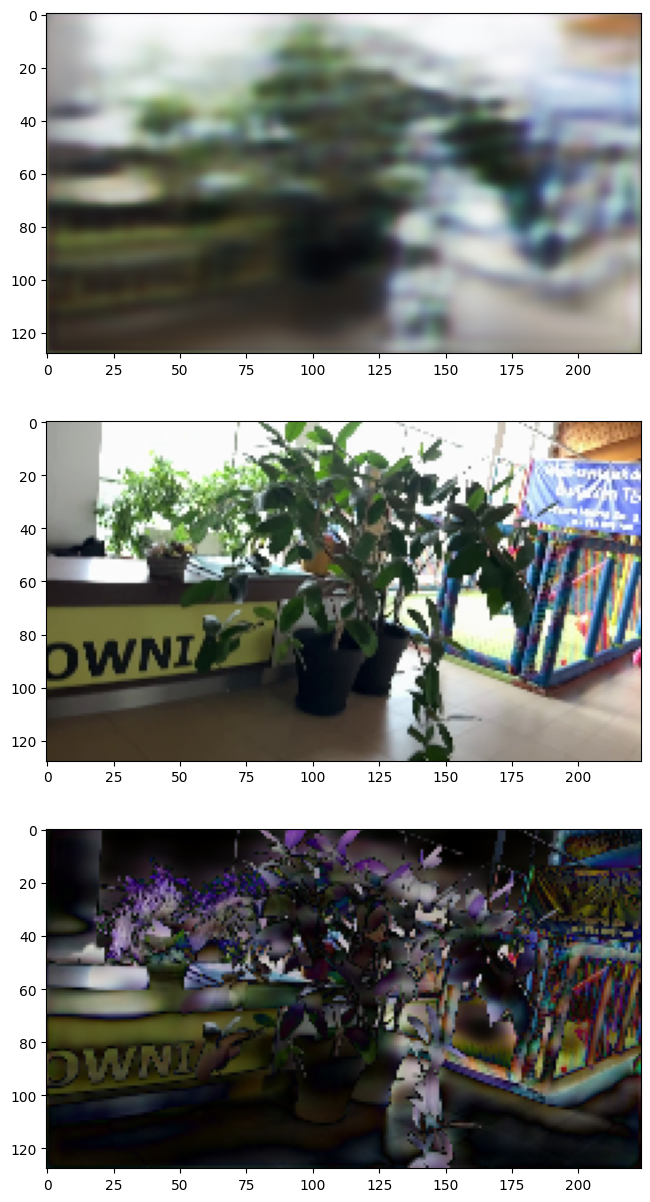

In [29]:
f, ax = plt.subplots(3, 1)
f.set_size_inches(10, 15)

index = 0
ax[0].imshow(predictions[index])
ax[1].imshow(y_test[index])
ax[2].imshow(cv2.absdiff(predictions[index], y_test[index]))

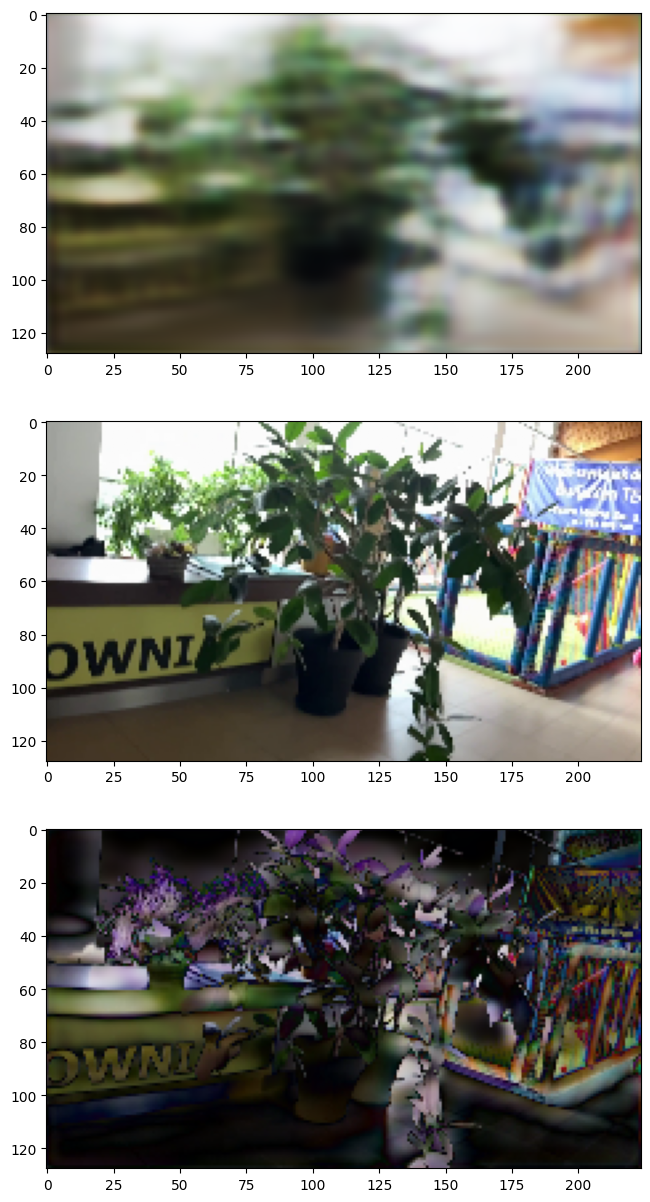

In [19]:
f, ax = plt.subplots(3, 1)
f.set_size_inches(10, 15)

index = 0
ax[0].imshow(predictions[index])
ax[1].imshow(y_test[index])
ax[2].imshow(cv2.absdiff(predictions[index], y_test[index]))